# CycleGAN - akahara imori <-> madara imori


In [ ]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [16]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *
from pprint import pprint
from torchsummary import summary

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = OrderedDict({
    'background' : [0, 0, 0],
    'akahara' : [0,0,128],
    'madara' : [0,128,0]
      }) # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 64
cfg.INPUT_WIDTH = 64
cfg.INPUT_CHANNEL = 3
cfg.INPUT_MODE = 'RGB'

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = cfg.CLASS_NUM
cfg.OUTPUT_MODE = 'CLASS_LABEL'  # RGB, GRAY, EDGE, CLASS_LABEL
cfg.OUTPUT_CMAP = None # pyplot cmap

cfg.G_DIM = 16
cfg.D_DIM = 16

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'CycleGAN'
cfg.TRAIN.MODEL_G_F_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_F_{}.pt'
cfg.TRAIN.MODEL_G_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_G_{}.pt'
cfg.TRAIN.MODEL_D_X_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_X_{}.pt'
cfg.TRAIN.MODEL_D_Y_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_Y_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 4
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0., 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0., 0.9)}


cfg.TRAIN.DATA_PATH = '../../Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = True # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = 1 # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

#---
# pix2pix  config
#---
cfg.PIX2PIX_LAMBDA = 10


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_F_PATH = cfg.TRAIN.MODEL_G_F_SAVE_PATH.format('final')
cfg.TEST.MODEL_G_G_PATH = cfg.TRAIN.MODEL_G_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '../../Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_F_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_G_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_X_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_Y_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': {'akahara': [0, 0, 128],
                 'background': [0, 0, 0],
                 'madara': [0, 128, 0]},
 'CLASS_NUM': 3,
 'DEVICE': device(type='cpu'),
 'D_DIM': 16,
 'GPU': False,
 'G_DIM': 16,
 'INPUT_CHANNEL': 3,
 'INPUT_HEIGHT': 64,
 'INPUT_MODE': 'RGB',
 'INPUT_WIDTH': 64,
 'OUTPUT_CHANNEL': 3,
 'OUTPUT_CMAP': None,
 'OUTPUT_HEIGHT': 64,
 'OUTPUT_MODE': 'CLASS_LABEL',
 'OUTPUT_WIDTH': 64,
 'PIX2PIX_LAMBDA': 10,
 'PREFIX': 'CycleGAN',
 'TEST': {'DATA_PATH': '../../Dataset/test/images/',
          'ITERATION': 2,
          'MINIBATCH': 10,
          'MODEL_G_F_PATH': 'models/CycleGAN_G_F_final.pt',
          'MODEL_G_G_PATH': 'models/CycleGAN_G_G_final.pt',
          'RESULT_IMAGE_PATH': 'result/CycleGAN_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': True,
           'DATA_PATH': '../../Dataset/train/images/',
           'DATA_ROTATION': 1,
           'DATA_VERTICAL_FLIP': True,
           'DISPAY_ITERATION

## Define Model

In [20]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class Encoder_block(torch.nn.Module):
    def __init__(self, dim1, dim2, name, stack_num=2):
        super(Encoder_block, self).__init__()
        _module = OrderedDict()
        for i in range(stack_num):
            f = dim1 if i == 0 else dim2
            _module['{}_stack_{}_conv'.format(name, i  + 1)] = torch.nn.Conv2d(f, dim2, kernel_size=3, padding=1, stride=1)
            _module['{}_stack_{}_act'.format(name, i + 1)] = torch.nn.ReLU()
            _module['{}_stack_{}_bn'.format(name, i + 1)] = torch.nn.BatchNorm2d(dim2)
            
        self.module = torch.nn.Sequential(_module)

    def forward(self, x):
        return self.module(x)

class Decoder_block(torch.nn.Module):
    def __init__(self, dim1, dim2, name):
        super(Decoder_block, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            '{}_transConv'.format(name) : torch.nn.ConvTranspose2d(dim1, dim2, kernel_size=2, stride=2),
            '{}_bn'.format(name) : torch.nn.BatchNorm2d(dim2)
        }))

    def forward(self, x):
        return self.module(x)

    
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        dim = cfg.G_DIM
        
        self.encoders = torch.nn.ModuleList([
            Encoder_block(cfg.INPUT_CHANNEL, dim, name='G_encoder_1'), 
            Encoder_block(dim, dim * 2, name='G_encoder_2'),
            Encoder_block(dim * 2, dim * 4, name='G_encoder_3'),
            Encoder_block(dim * 4, dim * 8, name='G_encoder_4'),
            Encoder_block(dim * 8, dim * 16, name='G_encoder_5'),
            Encoder_block(dim * 16, dim * 16, name='G_encoder_6'),
        ])
        
        self.decoders = torch.nn.ModuleList([
            Encoder_block(dim * 16, dim * 16, name='G_decoder_5'),
            Encoder_block(dim * 32, dim * 8, name='G_decoder_4'),
            Encoder_block(dim * 16, dim * 4, name='G_decoder_3'),
            Encoder_block(dim * 8, dim * 2, name='G_decoder_2'),
            Encoder_block(dim * 4, dim, name='G_decoder_1'),
        ])
            
        self.out = torch.nn.Sequential(OrderedDict({
            'G_out' : torch.nn.Conv2d(dim, cfg.OUTPUT_CHANNEL, kernel_size=3, padding=1, stride=1),
            'G_out_act' : torch.nn.Tanh()
        }))

        
    def forward(self, x):
        outputs = []
        # encoder
        for encoder in self.encoders[:-1]:
            x = encoder(x)
            outputs.append(x)
            x = F.max_pool2d(x, 2, stride=2, padding=0)
        
        x = self.encoders[-1](x)
        
        # decoder
        for i, decoder in enumerate(self.decoders[:-1]):
            x = decoder(x)
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = torch.cat([x, outputs[ - i - 1]], dim=1)
        
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.decoders[-1](x)
        return self.out(x)
        

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        dim = cfg.D_DIM
        
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1_conv' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, dim, kernel_size=5, padding=2, stride=2),
            'D_layer_1_act' : torch.nn.LeakyReLU(0.2),
            'D_layer_2_conv' : torch.nn.Conv2d(dim, dim * 2, kernel_size=5, padding=2, stride=2),
            'D_layer_2_act' : torch.nn.LeakyReLU(0.2),
            'D_layer_3_conv' : torch.nn.Conv2d(dim * 2, dim * 4, kernel_size=5, padding=2, stride=2),
            'D_layer_3_act' : torch.nn.LeakyReLU(0.2),
            'D_layer_4_conv' : torch.nn.Conv2d(dim * 4, dim * 8, kernel_size=5, padding=2, stride=2),
            'D_layer_4_act' : torch.nn.LeakyReLU(0.2),
            'D_flatten' : Flatten(),
            'D_out' : torch.nn.Linear((cfg.OUTPUT_HEIGHT // 16) * (cfg.OUTPUT_WIDTH // 16) * dim * 8, 1),
            'D_out_act' : torch.nn.Sigmoid()
        }))
        
    def forward(self, x):
        return self.module(x)
    
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

## Utility

In [21]:
def result_show(model, Xs, path=None, save=False, show=False, figsize=(12, 4), cmap=None):
    _Xs = Xs.detach().cpu().numpy()
    _Xs = (_Xs * 127.5 + 127.5).astype(np.uint8)
    
    ys = model(Xs).detach().cpu().numpy()
    ys = (ys * 127.5 + 127.5).astype(np.uint8)
    ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    
    if cfg.OUTPUT_CHANNEL == 1:
        _Xs = _Xs[:, 0]
        ys = ys[:, 0]
    else:
        _Xs = _Xs.transpose(0, 2, 3, 1)
        ys = ys.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(ys))
        
    plt.figure(figsize=figsize)
    for i in range(show_max):
        # show input
        _X = _Xs[i]
        plt.subplot(2, show_max, i + 1)
        plt.imshow(_X, cmap=cmap)
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        _y = ys[i]
        plt.subplot(2, show_max, i + 1 + show_max)
        plt.imshow(_y, cmap=cmap)
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

## Train

 50%|█████     | 8/16 [00:00<00:00, 3463.15it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
       BatchNorm2d-3           [-1, 16, 64, 64]              32
            Conv2d-4           [-1, 16, 64, 64]           2,320
              ReLU-5           [-1, 16, 64, 64]               0
       BatchNorm2d-6           [-1, 16, 64, 64]              32
     Encoder_block-7           [-1, 16, 64, 64]               0
            Conv2d-8           [-1, 32, 32, 32]           4,640
              ReLU-9           [-1, 32, 32, 32]               0
      BatchNorm2d-10           [-1, 32, 32, 32]              64
           Conv2d-11           [-1, 32, 32, 32]           9,248
             ReLU-12           [-1, 32, 32, 32]               0
      BatchNorm2d-13           [-1, 32, 32, 32]              64
    Encoder_block-14           [-1, 32,


/Users/yoshitonagaoka/dev/miniconda3/envs/jupyter/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Iter:50, LossG_G:13.3015, LossG_F:13.0174, LossD_X:0.0016, LossD_Y:0.0007
Iter:100, LossG_G:9.0784, LossG_F:8.8915, LossD_X:0.0001, LossD_Y:0.0000
Iter:150, LossG_G:6.8913, LossG_F:7.1582, LossD_X:0.0000, LossD_Y:0.0000
Iter:200, LossG_G:4.7303, LossG_F:4.7732, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter200.pt, D >> models/CycleGAN_D_X_iter200.pt
Iter:250, LossG_G:4.8447, LossG_F:5.2290, LossD_X:0.0000, LossD_Y:0.0000
Iter:300, LossG_G:4.2243, LossG_F:4.1835, LossD_X:0.0000, LossD_Y:0.0000
Iter:350, LossG_G:4.1809, LossG_F:4.3171, LossD_X:0.0000, LossD_Y:0.0000
Iter:400, LossG_G:3.5788, LossG_F:3.6252, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter400.pt, D >> models/CycleGAN_D_X_iter400.pt
Iter:450, LossG_G:3.4360, LossG_F:3.4242, LossD_X:0.0000, LossD_Y:0.0000
Iter:500, LossG_G:3.7297, LossG_F:3.9128, LossD_X:0.0000, LossD_Y:0.0000
result was saved to >> result/CycleGAN_result_G_iter500.jpg


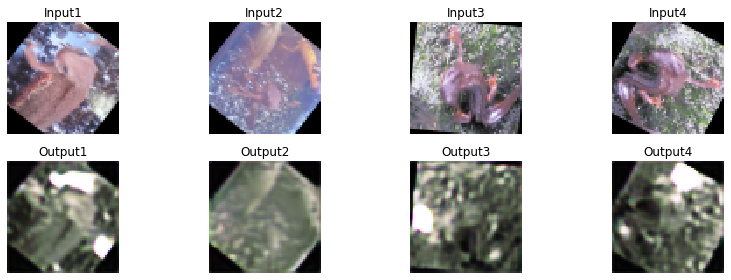

result was saved to >> result/CycleGAN_result_F_iter500.jpg


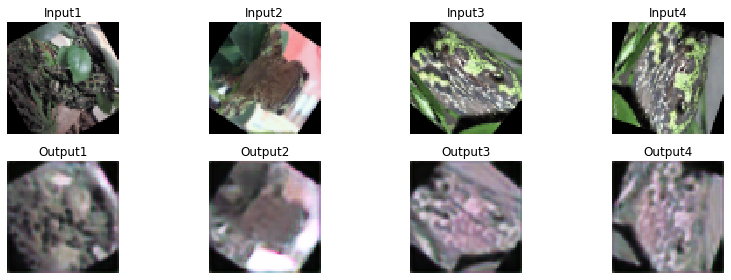

Iter:550, LossG_G:3.4391, LossG_F:3.3326, LossD_X:0.0000, LossD_Y:0.0000
Iter:600, LossG_G:2.9574, LossG_F:2.9304, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter600.pt, D >> models/CycleGAN_D_X_iter600.pt
Iter:650, LossG_G:3.4263, LossG_F:3.2336, LossD_X:0.0000, LossD_Y:0.0000
Iter:700, LossG_G:3.0503, LossG_F:2.9481, LossD_X:0.0000, LossD_Y:0.0000
Iter:750, LossG_G:2.8460, LossG_F:2.8578, LossD_X:0.0000, LossD_Y:0.0000
Iter:800, LossG_G:2.8945, LossG_F:2.9160, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter800.pt, D >> models/CycleGAN_D_X_iter800.pt
Iter:850, LossG_G:2.7726, LossG_F:2.7587, LossD_X:0.0000, LossD_Y:0.0000
Iter:900, LossG_G:2.7134, LossG_F:2.6907, LossD_X:0.0000, LossD_Y:0.0000
Iter:950, LossG_G:3.0813, LossG_F:2.9292, LossD_X:0.0000, LossD_Y:0.0000
Iter:1000, LossG_G:2.9657, LossG_F:2.8656, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter1000.pt, D >> models/CycleGAN_D_X_iter1000.pt
result was saved to >> result/Cyc

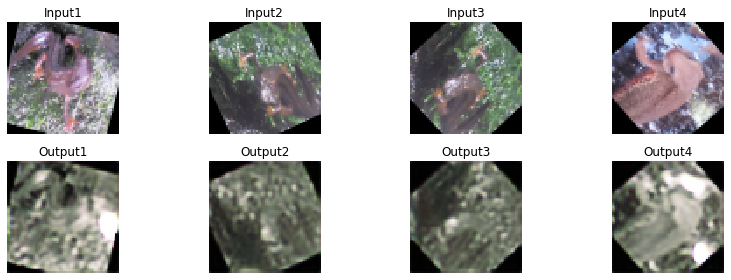

result was saved to >> result/CycleGAN_result_F_iter1000.jpg


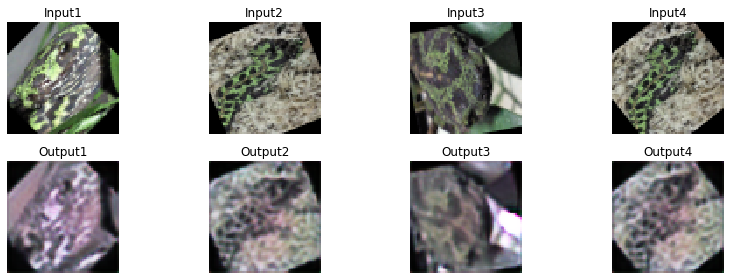

Iter:1050, LossG_G:2.6653, LossG_F:2.5975, LossD_X:0.0000, LossD_Y:0.0000
Iter:1100, LossG_G:3.4189, LossG_F:3.5269, LossD_X:0.0000, LossD_Y:0.0000
Iter:1150, LossG_G:2.7341, LossG_F:2.6215, LossD_X:0.0000, LossD_Y:0.0000
Iter:1200, LossG_G:2.9458, LossG_F:3.0058, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter1200.pt, D >> models/CycleGAN_D_X_iter1200.pt
Iter:1250, LossG_G:2.8311, LossG_F:2.8564, LossD_X:0.0000, LossD_Y:0.0000
Iter:1300, LossG_G:2.4890, LossG_F:2.4716, LossD_X:0.0000, LossD_Y:0.0000
Iter:1350, LossG_G:3.4990, LossG_F:3.6396, LossD_X:0.0000, LossD_Y:0.0000
Iter:1400, LossG_G:3.2385, LossG_F:3.3245, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter1400.pt, D >> models/CycleGAN_D_X_iter1400.pt
Iter:1450, LossG_G:2.7812, LossG_F:2.7539, LossD_X:0.0000, LossD_Y:0.0000
Iter:1500, LossG_G:2.9493, LossG_F:3.0175, LossD_X:0.0000, LossD_Y:0.0000
result was saved to >> result/CycleGAN_result_G_iter1500.jpg


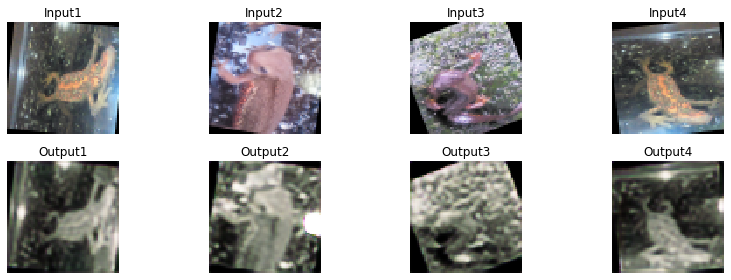

result was saved to >> result/CycleGAN_result_F_iter1500.jpg


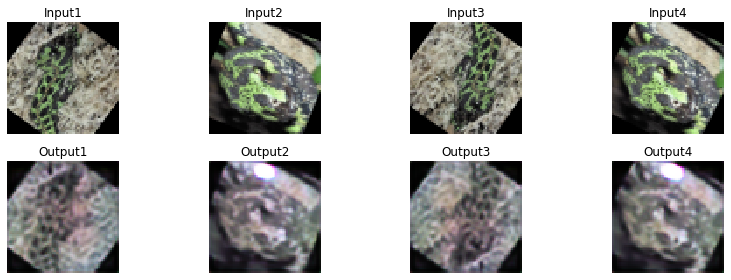

Iter:1550, LossG_G:2.7409, LossG_F:2.9512, LossD_X:0.0000, LossD_Y:0.0000
Iter:1600, LossG_G:2.7244, LossG_F:2.8131, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter1600.pt, D >> models/CycleGAN_D_X_iter1600.pt
Iter:1650, LossG_G:2.5758, LossG_F:2.4639, LossD_X:0.0000, LossD_Y:0.0000
Iter:1700, LossG_G:2.5183, LossG_F:2.5630, LossD_X:0.0000, LossD_Y:0.0000
Iter:1750, LossG_G:3.7913, LossG_F:4.0590, LossD_X:0.0000, LossD_Y:0.0000
Iter:1800, LossG_G:2.2304, LossG_F:2.2149, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter1800.pt, D >> models/CycleGAN_D_X_iter1800.pt
Iter:1850, LossG_G:2.7375, LossG_F:2.6516, LossD_X:0.0000, LossD_Y:0.0000
Iter:1900, LossG_G:2.6512, LossG_F:2.3894, LossD_X:0.0000, LossD_Y:0.0000
Iter:1950, LossG_G:2.4996, LossG_F:2.4029, LossD_X:0.0000, LossD_Y:0.0000
Iter:2000, LossG_G:3.1732, LossG_F:2.8877, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter2000.pt, D >> models/CycleGAN_D_X_iter2000.pt
result was saved to 

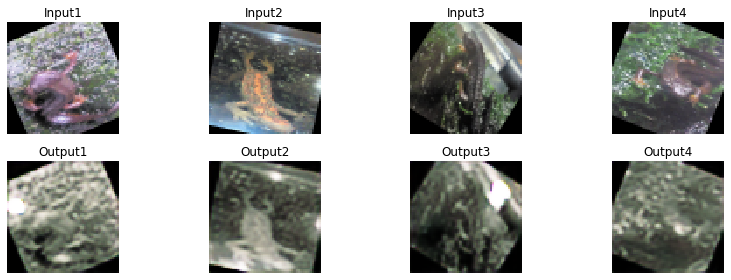

result was saved to >> result/CycleGAN_result_F_iter2000.jpg


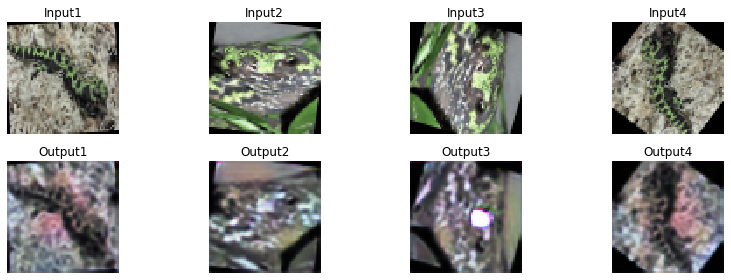

Iter:2050, LossG_G:2.4199, LossG_F:2.4241, LossD_X:0.0000, LossD_Y:0.0000
Iter:2100, LossG_G:2.9485, LossG_F:2.6595, LossD_X:0.0000, LossD_Y:0.0000
Iter:2150, LossG_G:2.4933, LossG_F:2.5032, LossD_X:0.0000, LossD_Y:0.0000
Iter:2200, LossG_G:2.2569, LossG_F:2.2120, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter2200.pt, D >> models/CycleGAN_D_X_iter2200.pt
Iter:2250, LossG_G:2.6281, LossG_F:2.4361, LossD_X:0.0000, LossD_Y:0.0000
Iter:2300, LossG_G:2.6541, LossG_F:2.5243, LossD_X:0.0000, LossD_Y:0.0000
Iter:2350, LossG_G:3.1337, LossG_F:3.0210, LossD_X:0.0000, LossD_Y:0.0000
Iter:2400, LossG_G:2.5997, LossG_F:2.6669, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter2400.pt, D >> models/CycleGAN_D_X_iter2400.pt
Iter:2450, LossG_G:2.9910, LossG_F:3.0850, LossD_X:0.0000, LossD_Y:0.0000
Iter:2500, LossG_G:2.2325, LossG_F:2.1368, LossD_X:0.0000, LossD_Y:0.0000
result was saved to >> result/CycleGAN_result_G_iter2500.jpg


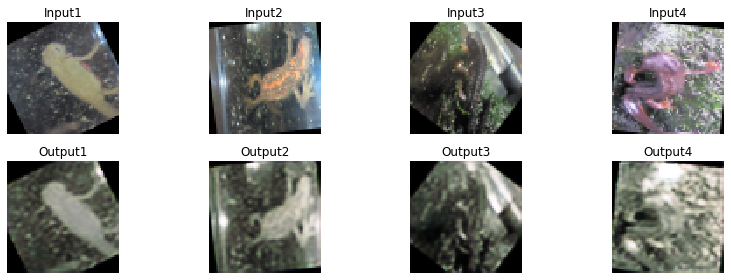

result was saved to >> result/CycleGAN_result_F_iter2500.jpg


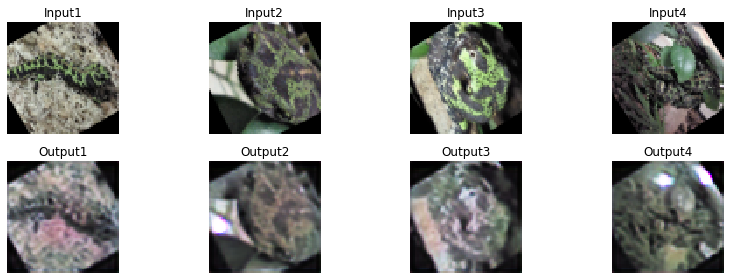

Iter:2550, LossG_G:2.3729, LossG_F:2.4178, LossD_X:0.0000, LossD_Y:0.0000
Iter:2600, LossG_G:2.6057, LossG_F:2.5703, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter2600.pt, D >> models/CycleGAN_D_X_iter2600.pt
Iter:2650, LossG_G:2.1756, LossG_F:2.1366, LossD_X:0.0000, LossD_Y:0.0000
Iter:2700, LossG_G:2.5210, LossG_F:2.3770, LossD_X:0.0000, LossD_Y:0.0000
Iter:2750, LossG_G:2.2076, LossG_F:2.1509, LossD_X:0.0000, LossD_Y:0.0000
Iter:2800, LossG_G:2.3616, LossG_F:2.4226, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter2800.pt, D >> models/CycleGAN_D_X_iter2800.pt
Iter:2850, LossG_G:2.0796, LossG_F:2.1193, LossD_X:0.0000, LossD_Y:0.0000
Iter:2900, LossG_G:2.0793, LossG_F:2.0855, LossD_X:0.0000, LossD_Y:0.0000
Iter:2950, LossG_G:2.1339, LossG_F:2.1218, LossD_X:0.0000, LossD_Y:0.0000
Iter:3000, LossG_G:2.3856, LossG_F:2.2733, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter3000.pt, D >> models/CycleGAN_D_X_iter3000.pt
result was saved to 

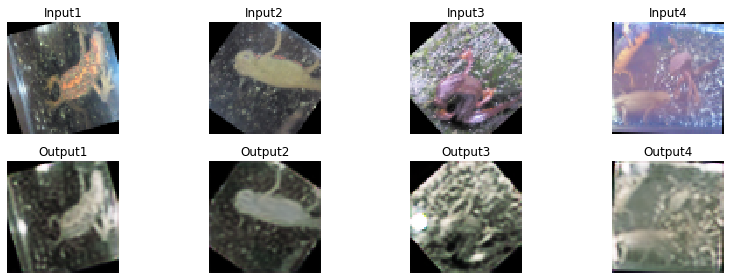

result was saved to >> result/CycleGAN_result_F_iter3000.jpg


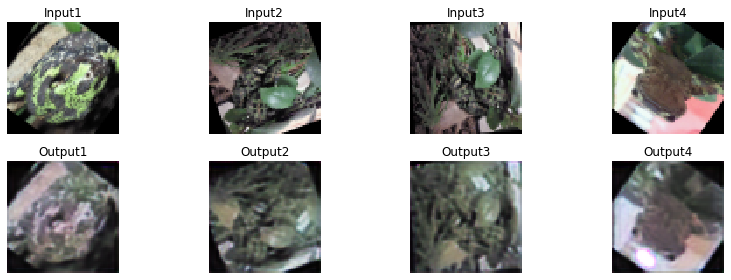

Iter:3050, LossG_G:2.1229, LossG_F:2.0433, LossD_X:0.0000, LossD_Y:0.0000
Iter:3100, LossG_G:2.3024, LossG_F:2.2958, LossD_X:0.0000, LossD_Y:0.0000
Iter:3150, LossG_G:2.0894, LossG_F:2.1124, LossD_X:0.0000, LossD_Y:0.0000
Iter:3200, LossG_G:2.0420, LossG_F:1.9652, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter3200.pt, D >> models/CycleGAN_D_X_iter3200.pt
Iter:3250, LossG_G:2.2547, LossG_F:2.2671, LossD_X:0.0000, LossD_Y:0.0000
Iter:3300, LossG_G:2.2735, LossG_F:2.1987, LossD_X:0.0000, LossD_Y:0.0000
Iter:3350, LossG_G:1.9889, LossG_F:1.9092, LossD_X:0.0000, LossD_Y:0.0000
Iter:3400, LossG_G:2.1965, LossG_F:2.1938, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter3400.pt, D >> models/CycleGAN_D_X_iter3400.pt
Iter:3450, LossG_G:2.2187, LossG_F:2.2916, LossD_X:0.0000, LossD_Y:0.0000
Iter:3500, LossG_G:2.5920, LossG_F:2.6234, LossD_X:0.0000, LossD_Y:0.0000
result was saved to >> result/CycleGAN_result_G_iter3500.jpg


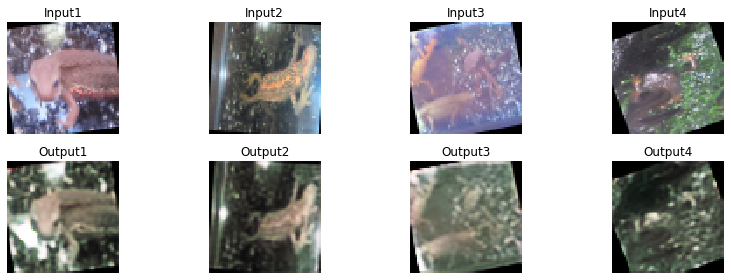

result was saved to >> result/CycleGAN_result_F_iter3500.jpg


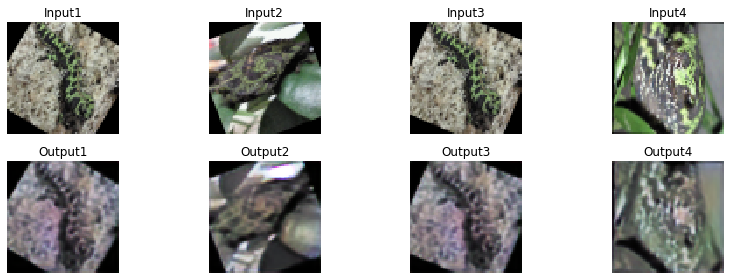

Iter:3550, LossG_G:2.1038, LossG_F:1.9517, LossD_X:0.0000, LossD_Y:0.0000
Iter:3600, LossG_G:2.1940, LossG_F:2.2605, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter3600.pt, D >> models/CycleGAN_D_X_iter3600.pt
Iter:3650, LossG_G:2.4512, LossG_F:2.6110, LossD_X:0.0000, LossD_Y:0.0000
Iter:3700, LossG_G:1.8188, LossG_F:1.8044, LossD_X:0.0000, LossD_Y:0.0000
Iter:3750, LossG_G:2.2037, LossG_F:2.1575, LossD_X:0.0000, LossD_Y:0.0000
Iter:3800, LossG_G:2.2256, LossG_F:2.3404, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter3800.pt, D >> models/CycleGAN_D_X_iter3800.pt
Iter:3850, LossG_G:2.2744, LossG_F:2.2993, LossD_X:0.0000, LossD_Y:0.0000
Iter:3900, LossG_G:2.1491, LossG_F:2.0487, LossD_X:0.0000, LossD_Y:0.0000
Iter:3950, LossG_G:2.3426, LossG_F:2.2612, LossD_X:0.0000, LossD_Y:0.0000
Iter:4000, LossG_G:1.9568, LossG_F:1.8515, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter4000.pt, D >> models/CycleGAN_D_X_iter4000.pt
result was saved to 

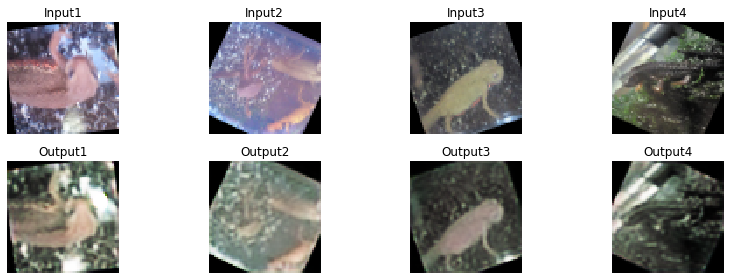

result was saved to >> result/CycleGAN_result_F_iter4000.jpg


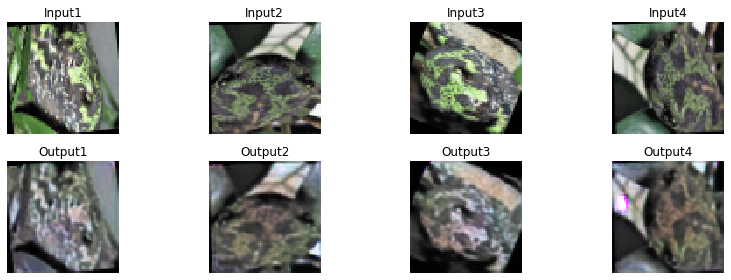

Iter:4050, LossG_G:2.0337, LossG_F:1.9172, LossD_X:0.0000, LossD_Y:0.0000
Iter:4100, LossG_G:2.0299, LossG_F:2.0669, LossD_X:0.0000, LossD_Y:0.0000
Iter:4150, LossG_G:2.2629, LossG_F:2.3078, LossD_X:0.0000, LossD_Y:0.0000
Iter:4200, LossG_G:1.7982, LossG_F:1.7812, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter4200.pt, D >> models/CycleGAN_D_X_iter4200.pt
Iter:4250, LossG_G:2.0903, LossG_F:2.1177, LossD_X:0.0000, LossD_Y:0.0000
Iter:4300, LossG_G:2.0927, LossG_F:2.0844, LossD_X:0.0000, LossD_Y:0.0000
Iter:4350, LossG_G:2.1451, LossG_F:2.0263, LossD_X:0.0000, LossD_Y:0.0000
Iter:4400, LossG_G:2.0404, LossG_F:2.0182, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter4400.pt, D >> models/CycleGAN_D_X_iter4400.pt
Iter:4450, LossG_G:2.0119, LossG_F:1.9901, LossD_X:0.0000, LossD_Y:0.0000
Iter:4500, LossG_G:1.9947, LossG_F:1.9837, LossD_X:0.0000, LossD_Y:0.0000
result was saved to >> result/CycleGAN_result_G_iter4500.jpg


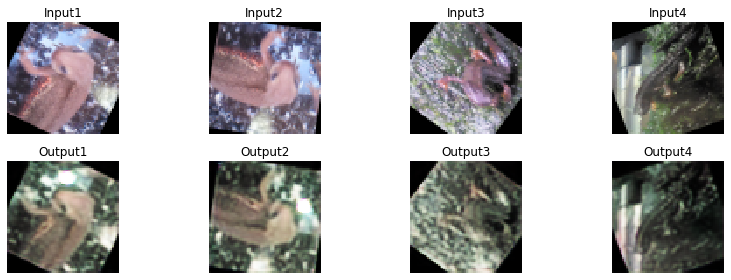

result was saved to >> result/CycleGAN_result_F_iter4500.jpg


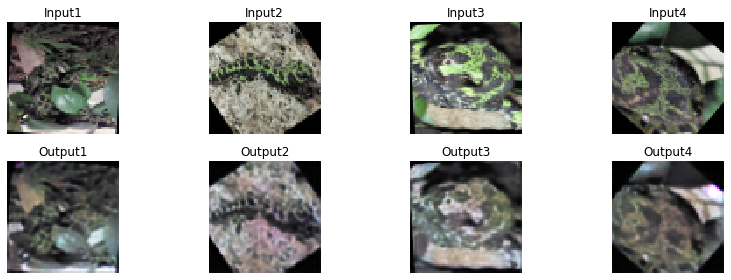

Iter:4550, LossG_G:2.3601, LossG_F:2.3085, LossD_X:0.0000, LossD_Y:0.0000
Iter:4600, LossG_G:1.9938, LossG_F:2.0197, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter4600.pt, D >> models/CycleGAN_D_X_iter4600.pt
Iter:4650, LossG_G:1.8596, LossG_F:1.8604, LossD_X:0.0000, LossD_Y:0.0000
Iter:4700, LossG_G:1.8684, LossG_F:1.7771, LossD_X:0.0000, LossD_Y:0.0000
Iter:4750, LossG_G:1.9875, LossG_F:1.8884, LossD_X:0.0000, LossD_Y:0.0000
Iter:4800, LossG_G:1.9287, LossG_F:1.9259, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter4800.pt, D >> models/CycleGAN_D_X_iter4800.pt
Iter:4850, LossG_G:1.9366, LossG_F:1.8507, LossD_X:0.0000, LossD_Y:0.0000
Iter:4900, LossG_G:1.9342, LossG_F:1.8932, LossD_X:0.0000, LossD_Y:0.0000
Iter:4950, LossG_G:2.0165, LossG_F:2.0431, LossD_X:0.0000, LossD_Y:0.0000
Iter:5000, LossG_G:1.7663, LossG_F:1.7848, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter5000.pt, D >> models/CycleGAN_D_X_iter5000.pt
result was saved to 

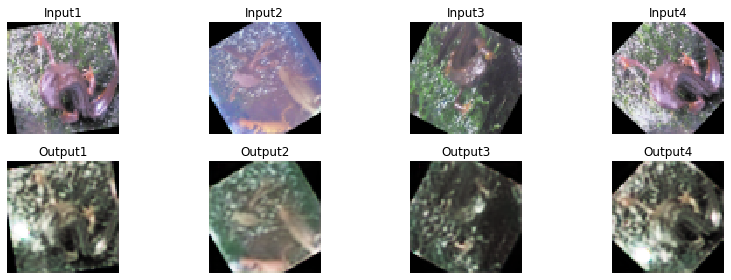

result was saved to >> result/CycleGAN_result_F_iter5000.jpg


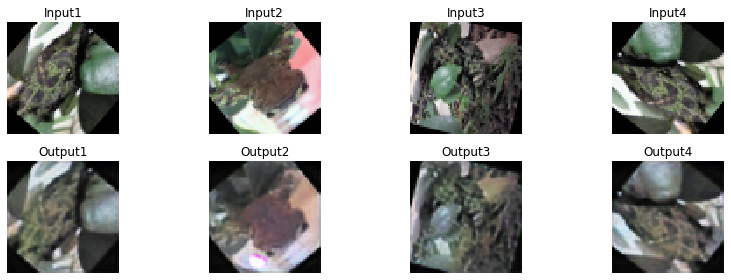

Iter:5050, LossG_G:2.5845, LossG_F:2.7990, LossD_X:0.0000, LossD_Y:0.0000
Iter:5100, LossG_G:1.7313, LossG_F:1.6818, LossD_X:0.0000, LossD_Y:0.0000
Iter:5150, LossG_G:1.8286, LossG_F:1.8248, LossD_X:0.0000, LossD_Y:0.0000
Iter:5200, LossG_G:1.5899, LossG_F:1.5849, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter5200.pt, D >> models/CycleGAN_D_X_iter5200.pt
Iter:5250, LossG_G:1.9605, LossG_F:1.9013, LossD_X:0.0000, LossD_Y:0.0000
Iter:5300, LossG_G:1.8698, LossG_F:1.8565, LossD_X:0.0000, LossD_Y:0.0000
Iter:5350, LossG_G:1.9681, LossG_F:1.9735, LossD_X:0.0000, LossD_Y:0.0000
Iter:5400, LossG_G:1.6974, LossG_F:1.6681, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter5400.pt, D >> models/CycleGAN_D_X_iter5400.pt
Iter:5450, LossG_G:1.7577, LossG_F:1.7513, LossD_X:0.0000, LossD_Y:0.0000
Iter:5500, LossG_G:2.0027, LossG_F:1.9093, LossD_X:0.0000, LossD_Y:0.0000
result was saved to >> result/CycleGAN_result_G_iter5500.jpg


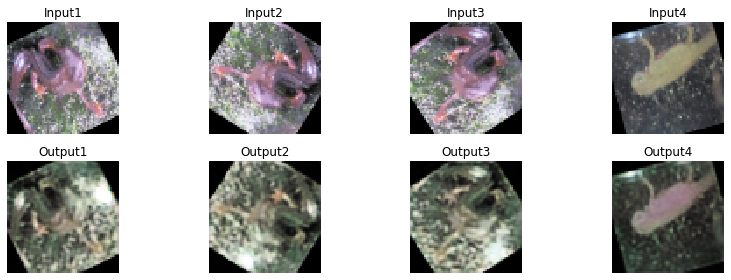

result was saved to >> result/CycleGAN_result_F_iter5500.jpg


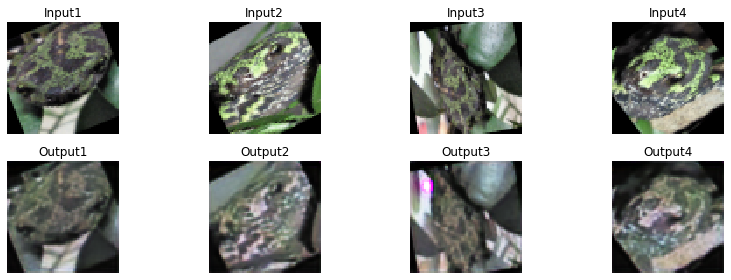

Iter:5550, LossG_G:1.8517, LossG_F:1.8295, LossD_X:0.0000, LossD_Y:0.0000
Iter:5600, LossG_G:1.8210, LossG_F:1.7656, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter5600.pt, D >> models/CycleGAN_D_X_iter5600.pt
Iter:5650, LossG_G:1.7891, LossG_F:1.7280, LossD_X:0.0000, LossD_Y:0.0000
Iter:5700, LossG_G:1.9445, LossG_F:1.9185, LossD_X:0.0000, LossD_Y:0.0000
Iter:5750, LossG_G:1.8278, LossG_F:1.8216, LossD_X:0.0000, LossD_Y:0.0000
Iter:5800, LossG_G:2.0160, LossG_F:1.9853, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter5800.pt, D >> models/CycleGAN_D_X_iter5800.pt
Iter:5850, LossG_G:1.8517, LossG_F:1.9530, LossD_X:0.0000, LossD_Y:0.0000
Iter:5900, LossG_G:1.8207, LossG_F:1.8195, LossD_X:0.0000, LossD_Y:0.0000
Iter:5950, LossG_G:1.8730, LossG_F:1.9184, LossD_X:0.0000, LossD_Y:0.0000
Iter:6000, LossG_G:2.0676, LossG_F:2.0564, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter6000.pt, D >> models/CycleGAN_D_X_iter6000.pt
result was saved to 

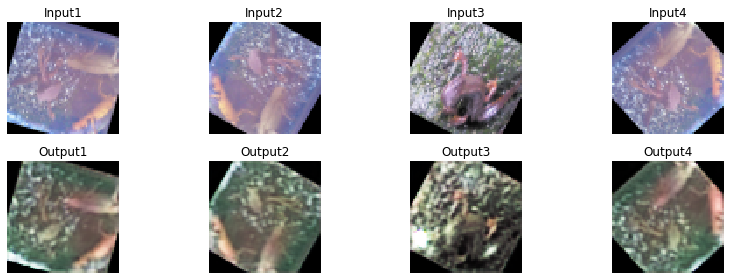

result was saved to >> result/CycleGAN_result_F_iter6000.jpg


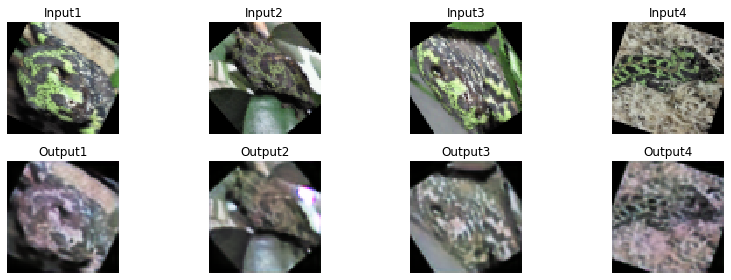

Iter:6050, LossG_G:1.8238, LossG_F:1.8423, LossD_X:0.0000, LossD_Y:0.0000
Iter:6100, LossG_G:1.6756, LossG_F:1.6762, LossD_X:0.0000, LossD_Y:0.0000
Iter:6150, LossG_G:1.7355, LossG_F:1.7860, LossD_X:0.0000, LossD_Y:0.0000
Iter:6200, LossG_G:1.6865, LossG_F:1.7429, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter6200.pt, D >> models/CycleGAN_D_X_iter6200.pt
Iter:6250, LossG_G:1.9794, LossG_F:1.8195, LossD_X:0.0000, LossD_Y:0.0000
Iter:6300, LossG_G:1.7124, LossG_F:1.6554, LossD_X:0.0000, LossD_Y:0.0000
Iter:6350, LossG_G:1.8290, LossG_F:1.7758, LossD_X:0.0000, LossD_Y:0.0000
Iter:6400, LossG_G:1.8007, LossG_F:1.8000, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter6400.pt, D >> models/CycleGAN_D_X_iter6400.pt
Iter:6450, LossG_G:1.6622, LossG_F:1.6195, LossD_X:0.0000, LossD_Y:0.0000
Iter:6500, LossG_G:1.8271, LossG_F:1.8681, LossD_X:0.0000, LossD_Y:0.0000
result was saved to >> result/CycleGAN_result_G_iter6500.jpg


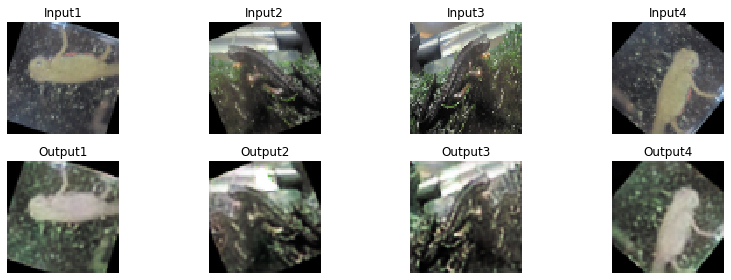

result was saved to >> result/CycleGAN_result_F_iter6500.jpg


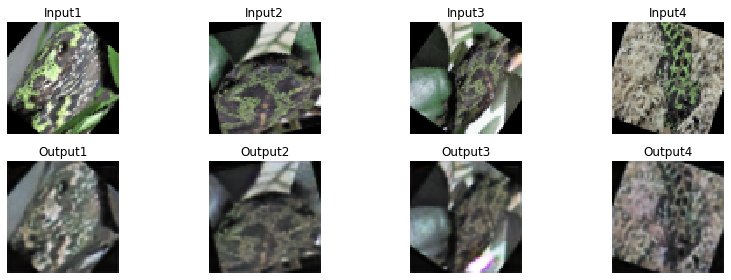

Iter:6550, LossG_G:1.6781, LossG_F:1.5654, LossD_X:0.0000, LossD_Y:0.0000
Iter:6600, LossG_G:1.5078, LossG_F:1.4728, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter6600.pt, D >> models/CycleGAN_D_X_iter6600.pt
Iter:6650, LossG_G:1.7418, LossG_F:1.7234, LossD_X:0.0000, LossD_Y:0.0000
Iter:6700, LossG_G:1.7029, LossG_F:1.6901, LossD_X:0.0000, LossD_Y:0.0000
Iter:6750, LossG_G:1.7632, LossG_F:1.8394, LossD_X:0.0000, LossD_Y:0.0000
Iter:6800, LossG_G:1.6579, LossG_F:1.6583, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter6800.pt, D >> models/CycleGAN_D_X_iter6800.pt
Iter:6850, LossG_G:1.7845, LossG_F:1.7402, LossD_X:0.0000, LossD_Y:0.0000
Iter:6900, LossG_G:1.8278, LossG_F:1.8334, LossD_X:0.0000, LossD_Y:0.0000
Iter:6950, LossG_G:1.7660, LossG_F:1.6678, LossD_X:0.0000, LossD_Y:0.0000
Iter:7000, LossG_G:2.0536, LossG_F:2.0090, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter7000.pt, D >> models/CycleGAN_D_X_iter7000.pt
result was saved to 

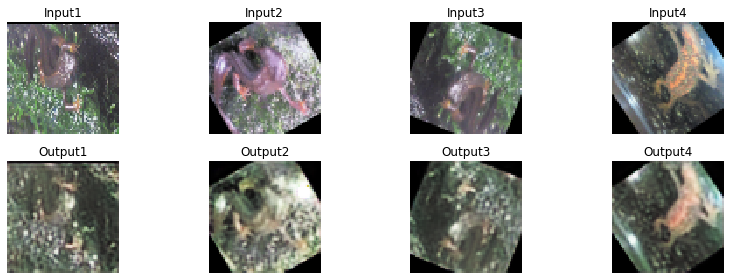

result was saved to >> result/CycleGAN_result_F_iter7000.jpg


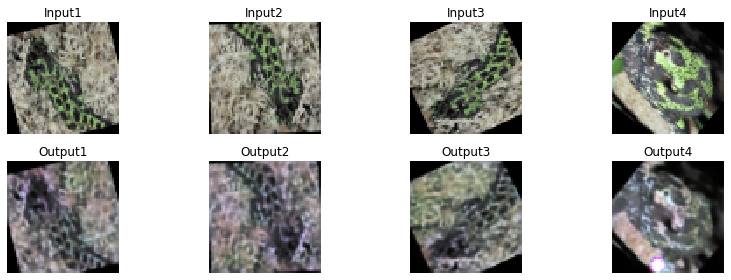

Iter:7050, LossG_G:1.8474, LossG_F:1.7718, LossD_X:0.0000, LossD_Y:0.0000
Iter:7100, LossG_G:1.8918, LossG_F:1.7536, LossD_X:0.0000, LossD_Y:0.0000
Iter:7150, LossG_G:1.6297, LossG_F:1.5801, LossD_X:0.0000, LossD_Y:0.0000
Iter:7200, LossG_G:1.5735, LossG_F:1.5910, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter7200.pt, D >> models/CycleGAN_D_X_iter7200.pt
Iter:7250, LossG_G:1.4883, LossG_F:1.5163, LossD_X:0.0000, LossD_Y:0.0000
Iter:7300, LossG_G:1.6906, LossG_F:1.5936, LossD_X:0.0000, LossD_Y:0.0000
Iter:7350, LossG_G:2.1045, LossG_F:2.1830, LossD_X:0.0000, LossD_Y:0.0000
Iter:7400, LossG_G:1.5528, LossG_F:1.4861, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter7400.pt, D >> models/CycleGAN_D_X_iter7400.pt
Iter:7450, LossG_G:1.7521, LossG_F:1.7495, LossD_X:0.0000, LossD_Y:0.0000
Iter:7500, LossG_G:1.9472, LossG_F:1.7966, LossD_X:0.0000, LossD_Y:0.0000
result was saved to >> result/CycleGAN_result_G_iter7500.jpg


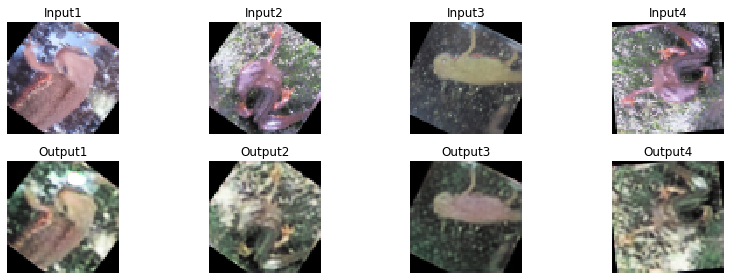

result was saved to >> result/CycleGAN_result_F_iter7500.jpg


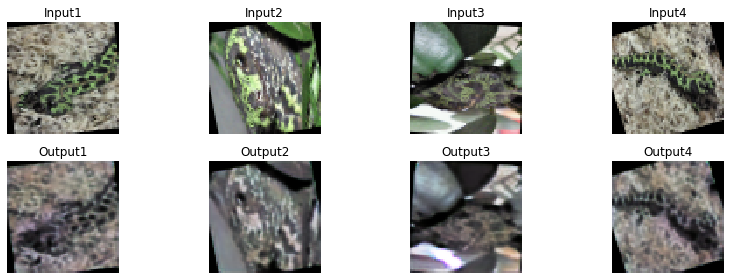

Iter:7550, LossG_G:1.7460, LossG_F:1.7035, LossD_X:0.0000, LossD_Y:0.0000
Iter:7600, LossG_G:1.8077, LossG_F:1.6890, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter7600.pt, D >> models/CycleGAN_D_X_iter7600.pt
Iter:7650, LossG_G:1.7961, LossG_F:1.7808, LossD_X:0.0000, LossD_Y:0.0000
Iter:7700, LossG_G:1.9916, LossG_F:1.9610, LossD_X:0.0000, LossD_Y:0.0000
Iter:7750, LossG_G:1.7551, LossG_F:1.6711, LossD_X:0.0000, LossD_Y:0.0000
Iter:7800, LossG_G:1.8010, LossG_F:1.7243, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter7800.pt, D >> models/CycleGAN_D_X_iter7800.pt
Iter:7850, LossG_G:1.7021, LossG_F:1.6596, LossD_X:0.0000, LossD_Y:0.0000
Iter:7900, LossG_G:1.6117, LossG_F:1.6338, LossD_X:0.0000, LossD_Y:0.0000
Iter:7950, LossG_G:1.7278, LossG_F:1.7071, LossD_X:0.0000, LossD_Y:0.0000
Iter:8000, LossG_G:1.6965, LossG_F:1.6920, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter8000.pt, D >> models/CycleGAN_D_X_iter8000.pt
result was saved to 

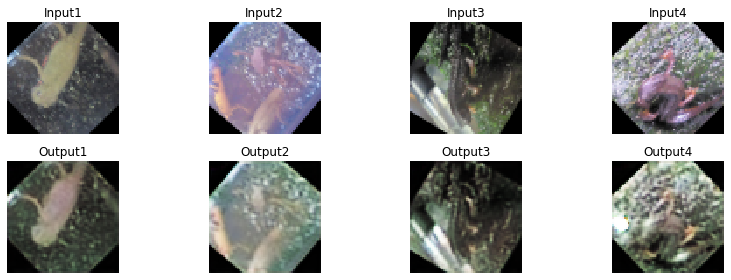

result was saved to >> result/CycleGAN_result_F_iter8000.jpg


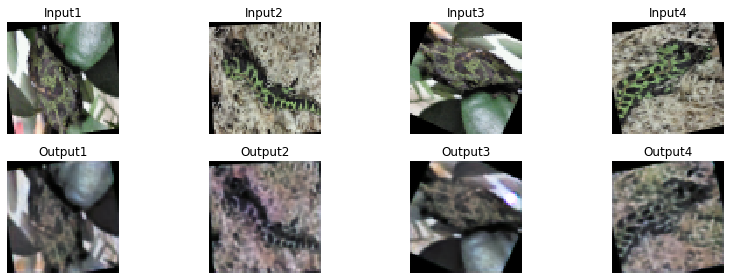

Iter:8050, LossG_G:1.4043, LossG_F:1.3960, LossD_X:0.0000, LossD_Y:0.0000
Iter:8100, LossG_G:1.5668, LossG_F:1.5183, LossD_X:0.0000, LossD_Y:0.0000
Iter:8150, LossG_G:1.7581, LossG_F:1.8076, LossD_X:0.0000, LossD_Y:0.0000
Iter:8200, LossG_G:1.6275, LossG_F:1.6255, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter8200.pt, D >> models/CycleGAN_D_X_iter8200.pt
Iter:8250, LossG_G:1.7831, LossG_F:1.7807, LossD_X:0.0000, LossD_Y:0.0000
Iter:8300, LossG_G:1.5442, LossG_F:1.4691, LossD_X:0.0000, LossD_Y:0.0000
Iter:8350, LossG_G:1.6500, LossG_F:1.6056, LossD_X:0.0000, LossD_Y:0.0000
Iter:8400, LossG_G:1.8467, LossG_F:1.6946, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter8400.pt, D >> models/CycleGAN_D_X_iter8400.pt
Iter:8450, LossG_G:1.5412, LossG_F:1.5223, LossD_X:0.0000, LossD_Y:0.0000
Iter:8500, LossG_G:1.6683, LossG_F:1.5791, LossD_X:0.0000, LossD_Y:0.0000
result was saved to >> result/CycleGAN_result_G_iter8500.jpg


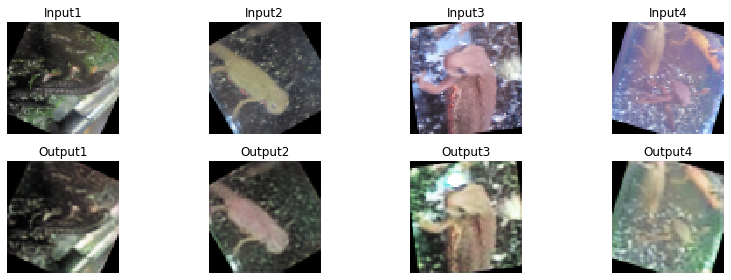

result was saved to >> result/CycleGAN_result_F_iter8500.jpg


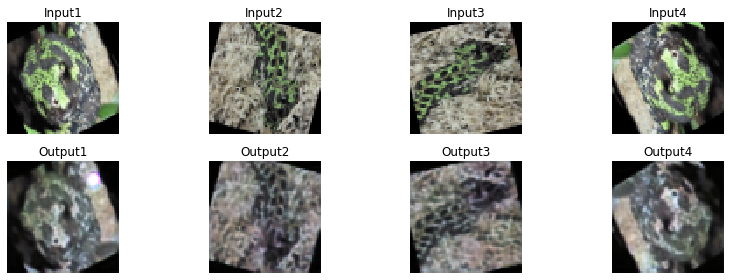

Iter:8550, LossG_G:1.5993, LossG_F:1.6361, LossD_X:0.0000, LossD_Y:0.0000
Iter:8600, LossG_G:1.5976, LossG_F:1.5978, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter8600.pt, D >> models/CycleGAN_D_X_iter8600.pt
Iter:8650, LossG_G:1.4770, LossG_F:1.4942, LossD_X:0.0000, LossD_Y:0.0000
Iter:8700, LossG_G:1.6749, LossG_F:1.6024, LossD_X:0.0000, LossD_Y:0.0000
Iter:8750, LossG_G:1.6327, LossG_F:1.6439, LossD_X:0.0000, LossD_Y:0.0000
Iter:8800, LossG_G:1.5530, LossG_F:1.5222, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter8800.pt, D >> models/CycleGAN_D_X_iter8800.pt
Iter:8850, LossG_G:1.6139, LossG_F:1.5565, LossD_X:0.0000, LossD_Y:0.0000
Iter:8900, LossG_G:1.7271, LossG_F:1.6486, LossD_X:0.0000, LossD_Y:0.0000
Iter:8950, LossG_G:1.8353, LossG_F:1.7522, LossD_X:0.0000, LossD_Y:0.0000
Iter:9000, LossG_G:1.8193, LossG_F:1.8302, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter9000.pt, D >> models/CycleGAN_D_X_iter9000.pt
result was saved to 

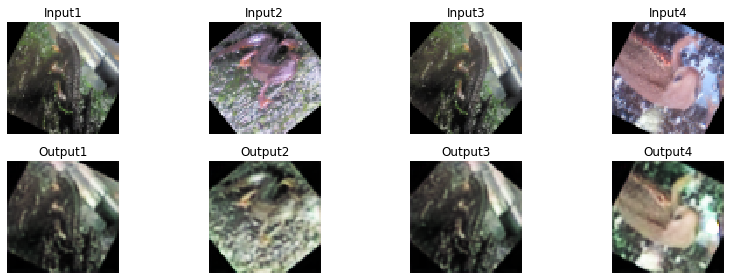

result was saved to >> result/CycleGAN_result_F_iter9000.jpg


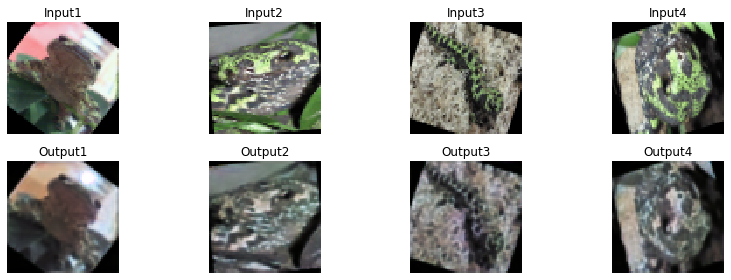

Iter:9050, LossG_G:1.5766, LossG_F:1.5178, LossD_X:0.0000, LossD_Y:0.0000
Iter:9100, LossG_G:1.8925, LossG_F:1.9596, LossD_X:0.0000, LossD_Y:0.0000
Iter:9150, LossG_G:1.5474, LossG_F:1.5384, LossD_X:0.0000, LossD_Y:0.0000
Iter:9200, LossG_G:1.5201, LossG_F:1.4379, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter9200.pt, D >> models/CycleGAN_D_X_iter9200.pt
Iter:9250, LossG_G:1.5407, LossG_F:1.5421, LossD_X:0.0000, LossD_Y:0.0000
Iter:9300, LossG_G:1.5712, LossG_F:1.5552, LossD_X:0.0000, LossD_Y:0.0000
Iter:9350, LossG_G:1.6030, LossG_F:1.6599, LossD_X:0.0000, LossD_Y:0.0000
Iter:9400, LossG_G:1.6120, LossG_F:1.5196, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter9400.pt, D >> models/CycleGAN_D_X_iter9400.pt
Iter:9450, LossG_G:1.6377, LossG_F:1.6155, LossD_X:0.0000, LossD_Y:0.0000
Iter:9500, LossG_G:1.5638, LossG_F:1.5916, LossD_X:0.0000, LossD_Y:0.0000
result was saved to >> result/CycleGAN_result_G_iter9500.jpg


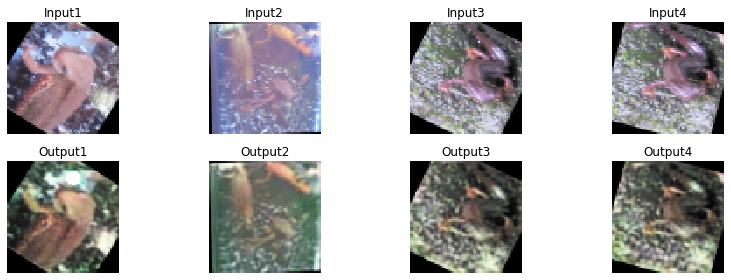

result was saved to >> result/CycleGAN_result_F_iter9500.jpg


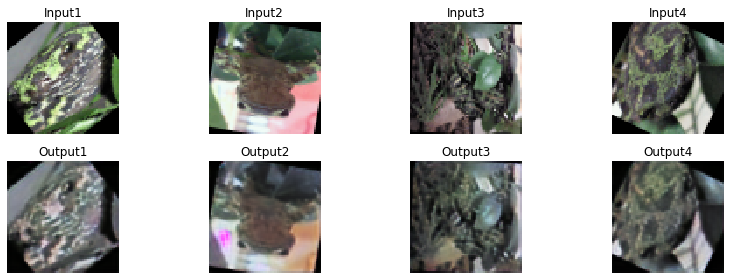

Iter:9550, LossG_G:1.5989, LossG_F:1.4854, LossD_X:0.0000, LossD_Y:0.0000
Iter:9600, LossG_G:1.3265, LossG_F:1.3528, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter9600.pt, D >> models/CycleGAN_D_X_iter9600.pt
Iter:9650, LossG_G:1.4438, LossG_F:1.4266, LossD_X:0.0000, LossD_Y:0.0000
Iter:9700, LossG_G:2.0313, LossG_F:2.3571, LossD_X:0.0000, LossD_Y:0.0000
Iter:9750, LossG_G:1.4509, LossG_F:1.3882, LossD_X:0.0000, LossD_Y:0.0000
Iter:9800, LossG_G:1.3531, LossG_F:1.3648, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter9800.pt, D >> models/CycleGAN_D_X_iter9800.pt
Iter:9850, LossG_G:1.5564, LossG_F:1.5251, LossD_X:0.0000, LossD_Y:0.0000
Iter:9900, LossG_G:1.5094, LossG_F:1.5522, LossD_X:0.0000, LossD_Y:0.0000
Iter:9950, LossG_G:1.4379, LossG_F:1.4751, LossD_X:0.0000, LossD_Y:0.0000
Iter:10000, LossG_G:1.6667, LossG_F:1.7447, LossD_X:0.0000, LossD_Y:0.0000
save G >> models/CycleGAN_G_G_iter10000.pt, D >> models/CycleGAN_D_X_iter10000.pt
result was saved 

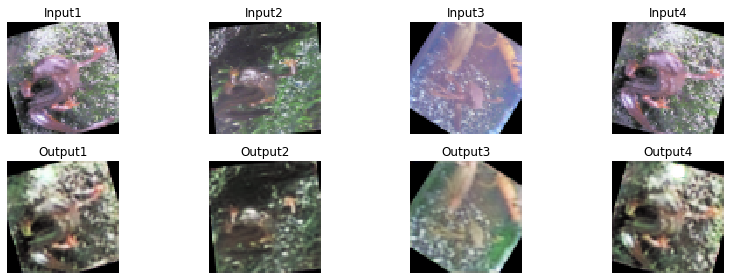

result was saved to >> result/CycleGAN_result_F_iter10000.jpg


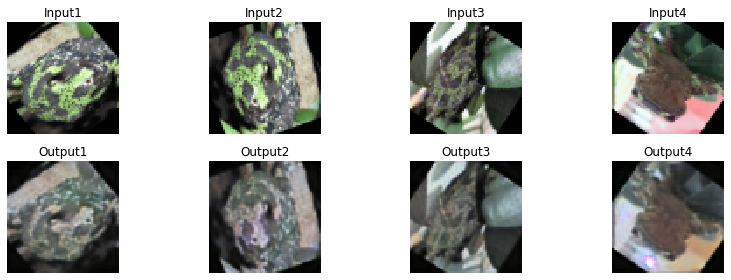

save G >> models/CycleGAN_G_G_iter10000.pt, D >> models/CycleGAN_D_X_iter10000.pt
loss was saved to >> result/CycleGAN_loss.txt


In [22]:
# train
def train():
    # model
    G_F = Generator().to(cfg.DEVICE)
    G_G = Generator().to(cfg.DEVICE)
    D_X = Discriminator().to(cfg.DEVICE)
    D_Y = Discriminator().to(cfg.DEVICE)
    summary(G_G,(cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    summary(D_X,(cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH))
    
    G_F.apply(weights_init)
    G_G.apply(weights_init)
    D_X.apply(weights_init)
    D_Y.apply(weights_init)

    opt_G_F = cfg.TRAIN.OPTIMIZER_G(G_F.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_G_G = cfg.TRAIN.OPTIMIZER_G(G_G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D_X = cfg.TRAIN.OPTIMIZER_D(D_X.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)
    opt_D_Y = cfg.TRAIN.OPTIMIZER_D(D_Y.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict_1 = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, 
                                                              rot=cfg.TRAIN.DATA_ROTATION, target_label='akahara')
    paths_1 = path_dict_1['paths']
    
    path_dict_2 = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, 
                                                              rot=cfg.TRAIN.DATA_ROTATION, target_label='madara')
    paths_2 = path_dict_2['paths']
    #paths_gt = path_dict['paths_gt']
    
    # training
    mbi_1 = 0
    mbi_2 = 0
    train_N_1 = len(paths_1)
    train_N_2 = len(paths_2)
    train_ind_1 = np.arange(train_N_1)
    train_ind_2 = np.arange(train_N_2)
    np.random.seed(0)
    np.random.shuffle(train_ind_1)
    np.random.shuffle(train_ind_2)

    list_iter = []
    list_loss_G_G = []
    list_loss_G_G_fake= []
    list_loss_G_G_identity = []
    list_loss_G_F = []
    list_loss_G_F_fake = []
    list_loss_G_F_identity = []
    list_loss_G_cycle_GF = []
    list_loss_G_cycle_FG = []
    list_loss_G_cycle = []
    
    list_loss_D_X = []
    list_loss_D_X_real = []
    list_loss_D_X_fake = []
    list_loss_D_Y = []
    list_loss_D_Y_real = []
    list_loss_D_Y_fake = []

    ones = torch.zeros([cfg.TRAIN.MINIBATCH], dtype=torch.float).to(cfg.DEVICE)
    zeros = ones * 0
    
    loss_bce = torch.nn.BCELoss(reduction='sum')
    loss_l1 = torch.nn.L1Loss(reduction='sum')

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi_1 + cfg.TRAIN.MINIBATCH > train_N_1:
            mb_ind_1 = train_ind_1[mbi_1:]
            np.random.shuffle(train_ind_1)
            mb_ind_1 = np.hstack((mb_ind_1, train_ind_1[ : (cfg.TRAIN.MINIBATCH - (train_N_1 - mbi_1))]))
            mbi_1 = cfg.TRAIN.MINIBATCH - (train_N_1 - mbi_1)
        else:
            mb_ind_1 = train_ind_1[mbi_1 : mbi_1 + cfg.TRAIN.MINIBATCH]
            mbi_1 += cfg.TRAIN.MINIBATCH
            
        if mbi_2 + cfg.TRAIN.MINIBATCH > train_N_2:
            mb_ind_2 = train_ind_2[mbi_2:]
            np.random.shuffle(train_ind_2)
            mb_ind_2 = np.hstack((mb_ind_2, train_ind_2[ : (cfg.TRAIN.MINIBATCH - (train_N_2 - mbi_2))]))
            mbi_2 = cfg.TRAIN.MINIBATCH - (train_N_2 - mbi_2)
        else:
            mb_ind_2 = train_ind_2[mbi_2 : mbi_2 + cfg.TRAIN.MINIBATCH]
            mbi_2 += cfg.TRAIN.MINIBATCH

        # update D
        opt_D_X.zero_grad()
        opt_D_Y.zero_grad()
        opt_G_G.zero_grad()
        opt_G_F.zero_grad()

        # sample X
        real_x = torch.tensor(get_image(paths_1[mb_ind_1], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        real_y = torch.tensor(get_image(paths_2[mb_ind_2], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        
        # real_x > G_G > G_F > cycled_x
        fake_y = G_G(real_x)
        cycled_x = G_F(fake_y)
        
        # real_y > G_F > G_G > cycled_y
        fake_x = G_F(real_y)
        cycled_y = G_G(fake_x)
        
        # identity map
        same_x = G_F(real_x)
        same_y = G_G(real_y)
        
        D_real_x = D_X(real_x)
        D_real_y = D_Y(real_y)
        
        D_fake_x = D_X(fake_x)
        D_fake_y = D_Y(fake_y)
        
        # D loss
        loss_D_X_real = loss_bce(D_real_x, ones)
        loss_D_X_fake = loss_bce(D_fake_x, zeros)
        loss_D_X = loss_D_X_real + loss_D_X_fake
        loss_D_X.backward(retain_graph=True)
        
        loss_D_Y_real = loss_bce(D_real_y, ones)
        loss_D_Y_fake = loss_bce(D_fake_y, zeros)
        loss_D_Y = loss_D_Y_real + loss_D_Y_fake
        loss_D_Y.backward(retain_graph=True)
        
        # Disciminator loss
        loss_G_G_fake = loss_bce(D_fake_y, ones)
        loss_G_F_fake = loss_bce(D_fake_x, ones)
        
        # Cycle loss
        loss_G_cycle_GF = cfg.PIX2PIX_LAMBDA * torch.abs(real_x - cycled_x).mean()
        loss_G_cycle_FG = cfg.PIX2PIX_LAMBDA * torch.abs(real_y - cycled_y).mean()
        loss_G_cycle = loss_G_cycle_GF + loss_G_cycle_FG
        
        # Identity loss
        loss_G_G_identity = cfg.PIX2PIX_LAMBDA * 0.5 * torch.abs(real_y - same_y).mean()
        loss_G_F_identity = cfg.PIX2PIX_LAMBDA * 0.5 * torch.abs(real_x - same_x).mean()
        
        # G loss
        loss_G_G = loss_G_G_fake + loss_G_cycle + loss_G_G_identity
        loss_G_F = loss_G_F_fake + loss_G_cycle + loss_G_F_identity
        loss_G_G.backward(retain_graph=True)
        loss_G_F.backward()

        # update
        opt_D_X.step()
        opt_D_Y.step()
        
        opt_G_G.step()
        opt_G_F.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_D_X_real = loss_D_X_real.item()
        _loss_D_X_fake = loss_D_X_fake.item()
        _loss_D_X = loss_D_X.item()
        
        _loss_D_Y_real = loss_D_Y_real.item()
        _loss_D_Y_fake = loss_D_Y_fake.item()
        _loss_D_Y = loss_D_Y.item()
        
        _loss_G_G_fake = loss_G_G_fake.item()
        _loss_G_F_fake = loss_G_F_fake.item()
        
        _loss_G_cycle_GF = loss_G_cycle_GF.item()
        _loss_G_cycle_FG = loss_G_cycle_FG.item()
        _loss_G_cycle = loss_G_cycle.item()
        
        _loss_G_G_identity = loss_G_G_identity.item()
        _loss_G_F_identity = loss_G_F_identity.item()
        
        _loss_G_G = loss_G_G.item()
        _loss_G_F = loss_G_F.item()


        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G_G.append(_loss_G_G)
                list_loss_G_F.append(_loss_G_F)            
                list_loss_G_G_identity.append(_loss_G_G_identity)
                list_loss_G_F_identity.append(_loss_G_F_identity)
                list_loss_G_cycle_GF.append(_loss_G_cycle_GF)
                list_loss_G_cycle_FG.append(_loss_G_cycle_FG)
                list_loss_G_cycle.append(_loss_G_cycle)
                list_loss_G_G_fake.append(_loss_G_G_fake)
                list_loss_G_F_fake.append(_loss_G_F_fake)
                
                list_loss_D_X.append(_loss_D_X)
                list_loss_D_X_real.append(_loss_D_X_real)
                list_loss_D_X_fake.append(_loss_D_X_fake)
                list_loss_D_Y.append(_loss_D_Y)
                list_loss_D_Y_real.append(_loss_D_Y_real)
                list_loss_D_Y_fake.append(_loss_D_Y_fake)
                
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG_G:{:.4f}, LossG_F:{:.4f}, LossD_X:{:.4f}, LossD_Y:{:.4f}'.format(
                i + 1, _loss_G_G, _loss_G_F, _loss_D_X, _loss_D_Y))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_G_save_path = cfg.TRAIN.MODEL_G_G_SAVE_PATH.format('iter{}'.format(i + 1))
            G_F_save_path = cfg.TRAIN.MODEL_G_F_SAVE_PATH.format('iter{}'.format(i + 1))
            D_X_save_path = cfg.TRAIN.MODEL_D_X_SAVE_PATH.format('iter{}'.format(i + 1))
            D_Y_save_path = cfg.TRAIN.MODEL_D_Y_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G_G.state_dict(), G_G_save_path)
            torch.save(G_F.state_dict(), G_F_save_path)
            torch.save(D_X.state_dict(), D_X_save_path)
            torch.save(D_Y.state_dict(), D_Y_save_path)
            print('save G >> {}, D >> {}'.format(G_G_save_path, D_X_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G_G, real_x, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('G_iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)
            result_show(
                G_F, real_y, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('F_iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_G_save_path = cfg.TRAIN.MODEL_G_G_SAVE_PATH.format('final')
    G_F_save_path = cfg.TRAIN.MODEL_G_F_SAVE_PATH.format('final')
    D_X_save_path = cfg.TRAIN.MODEL_D_X_SAVE_PATH.format('final')
    D_Y_save_path = cfg.TRAIN.MODEL_D_Y_SAVE_PATH.format('final')
    torch.save(G_G.state_dict(), G_G_save_path)
    torch.save(G_F.state_dict(), G_F_save_path)
    torch.save(D_X.state_dict(), D_X_save_path)
    torch.save(D_Y.state_dict(), D_Y_save_path)
    print('save G >> {}, D >> {}'.format(G_G_save_path, D_X_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 
            'loss_G_G' : list_loss_G_G, 'loss_G_F_fake' : list_loss_G_G_fake,
            'loss_G_F' : list_loss_G_F, 'loss_G_F_fake' : list_loss_G_F_fake,
            'loss_G_G_identity' : list_loss_G_G_identity, 'loss_G_F_identity' : list_loss_G_F_identity,
            'loss_G_cycle' : list_loss_G_cycle, 'loss_G_cycle_GF' : list_loss_G_cycle_GF,
            'loss_G_cycle_FG' : list_loss_G_cycle_FG,
            'loss_D_X' : list_loss_D_X, 'loss_D_X_real' : list_loss_D_X_real,
            'loss_D_X_fake' : list_loss_D_X_fake, 'loss_D_Y' : list_loss_D_Y,
            'loss_D_Y_real' : list_loss_D_Y_real, 'loss_D_Y_fake' : list_loss_D_Y_fake
        })
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

 50%|█████     | 8/16 [00:00<00:00, 13623.40it/s]

--------------------
test function
--------------------
Dataset >> ../../Dataset/train/images/
 - Found data num >> 16
 - Horizontal >> False
 - Vertical >> False
 - Rotation >> False
all data num >> 8
dataset was completely loaded
--
Dataset >> ../../Dataset/train/images/
 - Found data num >> 16
 - Horizontal >> False
 - Vertical >> False
 - Rotation >> False
all data num >> 8
dataset was completely loaded
--


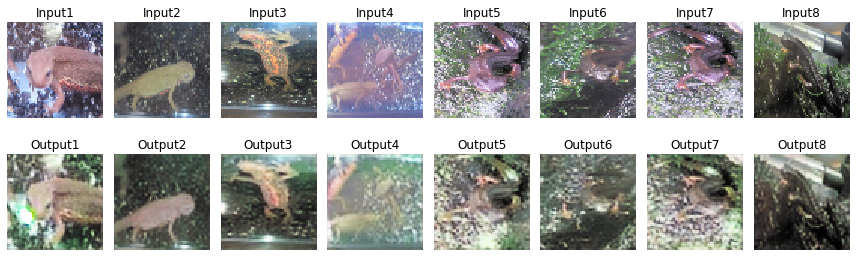

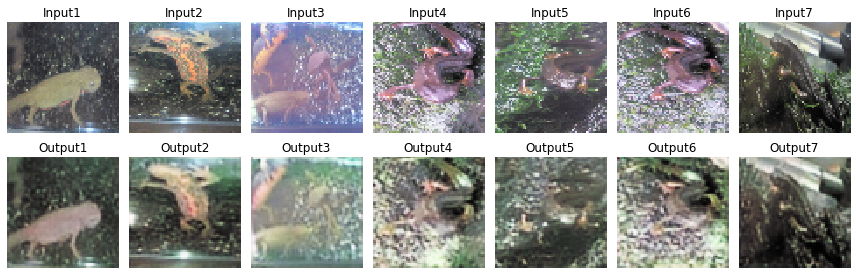

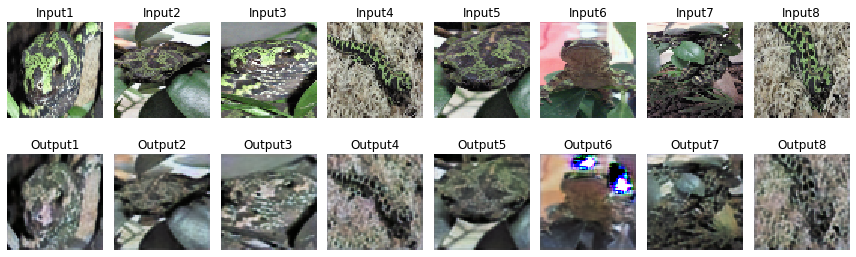

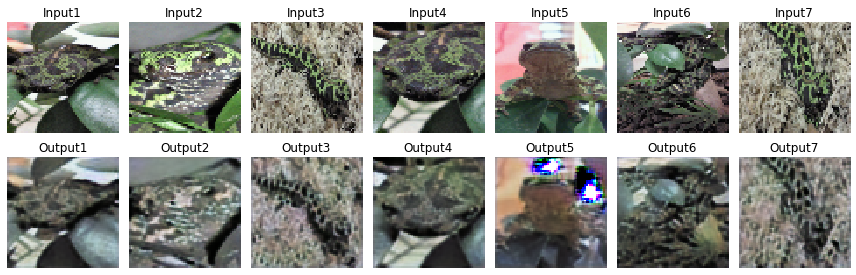

In [25]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G_G = Generator().to(cfg.DEVICE)
    G_G.load_state_dict(torch.load(cfg.TEST.MODEL_G_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G_G.eval()
    
    G_F = Generator().to(cfg.DEVICE)
    G_F.load_state_dict(torch.load(cfg.TEST.MODEL_G_F_PATH, map_location=torch.device(cfg.DEVICE)))
    G_F.eval()
    
    path_dict_1 = data_load(cfg, hf=False, vf=False, rot=False, target_label='akahara')
    paths_1 = path_dict_1['paths']
    
    path_dict_2 = data_load(cfg, hf=False, vf=False, rot=False, target_label='madara')
    paths_2 = path_dict_2['paths']

    np.random.seed(0)
    
    with torch.no_grad():
        Test_Num = len(paths_1)
        for i in range(cfg.TEST.ITERATION):
            # sample image
            mb_ind = np.arange(i, min(i + cfg.TEST.MINIBATCH, Test_Num))
            real_x = torch.tensor(get_image(paths_1[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
       
            result_show(G_G, real_x, cfg.TEST.RESULT_IMAGE_PATH.format('G_' + str(i + 1)), save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

    
        Test_Num = len(paths_1)
        for i in range(cfg.TEST.ITERATION):
            mb_ind = np.arange(i, min(i + cfg.TEST.MINIBATCH, Test_Num))
            real_y = torch.tensor(get_image(paths_2[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
         
            result_show(G_F, real_y, cfg.TEST.RESULT_IMAGE_PATH.format('G_' + str(i + 1)), save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

test()

In [ ]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
